<a href="https://colab.research.google.com/github/bkkaggle/jax-dcgan/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install flax

import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1
# The following is required to use TPU Driver as JAX's backend.
import os
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.7.83.234:8470


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial

import jax
import jax.numpy as jnp
import flax

import tensorflow as tf
import tensorflow_datasets as tfds

def shard(xs):
  return jax.tree_map(
      lambda x: x.reshape((jax.device_count(), -1) + x.shape[1:]), xs)

class Generator(flax.nn.Module):
    def apply(self, z, training):
        x = flax.nn.ConvTranspose(
            z, features=64*8, kernel_size=(4, 4), strides=(1, 1), padding='VALID', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.relu(x)

        x = flax.nn.ConvTranspose(
            x, features=64*4, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.relu(x)

        x = flax.nn.ConvTranspose(
            x, features=64*2, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.relu(x)

        x = flax.nn.ConvTranspose(
            x, features=64, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.relu(x)

        x = flax.nn.ConvTranspose(
            x, features=1, kernel_size=(4, 4), strides=(1, 1), padding='SAME', bias=False)
        return jnp.tanh(x)

class Discriminator(flax.nn.Module):
    def apply(self, x, training):
        x = flax.nn.Conv(x, features=64, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=64*2, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=64*4, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=64*8, kernel_size=(4, 4), strides=(2, 2), padding='SAME', bias=False)
        x = flax.nn.BatchNorm(
            x, use_running_average=not training, momentum=0.9)
        x = flax.nn.leaky_relu(x, negative_slope=0.2)

        x = flax.nn.Conv(x, features=1, kernel_size=(1, 1), strides=(4, 4), padding='VALID', bias=False)
        x = jnp.reshape(x, [x.shape[0], -1])

        return x

def make_dataset(batch_size, seed=1):
    mnist = tfds.load("mnist")

    def _preprocess(sample):
        image = tf.image.convert_image_dtype(sample["image"], tf.float32)
        image = tf.image.resize(image, (32, 32))
        return 2.0 * image - 1.0

    ds = mnist["train"]
    ds = ds.map(map_func=_preprocess,
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
    return iter(tfds.as_numpy(ds))

@jax.vmap
def bce_logits_loss(logit, label):
    return jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(-jnp.abs(logit)))

def loss_g(generator, discriminator, batch, rng, state_g, state_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    with flax.nn.stateful(state_g) as state_g:
        fake_batch = generator(z, training=True)

    with flax.nn.stateful(state_d) as state_d:
        fake_logits = discriminator(fake_batch, training=True)

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    return jnp.mean(bce_logits_loss(fake_logits, real_labels)), (state_g, state_d)

def loss_d(discriminator, generator, batch, rng, state_g, state_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    with flax.nn.stateful(state_g) as state_g:
        fake_batch = generator(z, training=True)

    with flax.nn.stateful(state_d) as state_d:
        real_logits = discriminator(batch, training=True)
    with flax.nn.stateful(state_d) as state_d:
        fake_logits = discriminator(fake_batch, training=True)

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    real_loss = bce_logits_loss(real_logits, real_labels)

    fake_labels = jnp.zeros((batch.shape[0],), dtype=jnp.int32)
    fake_loss = bce_logits_loss(fake_logits, fake_labels)

    return jnp.mean(real_loss + fake_loss), (state_g, state_d)

@partial(jax.pmap, axis_name='batch')
def train_step(rng, state_g, state_d, optimizer_g, optimizer_d, batch):
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    (g_loss, (state_g, state_d)), grad_g = jax.value_and_grad(loss_g, has_aux=True)(
        optimizer_g.target, optimizer_d.target, batch, rng_g, state_g, state_d)
    g_loss = jax.lax.pmean(g_loss, axis_name='batch')
    grad_g = jax.lax.pmean(grad_g, axis_name='batch')
    
    optimizer_g = optimizer_g.apply_gradient(grad_g)

    (d_loss, (state_g, state_d)), grad_d = jax.value_and_grad(loss_d, has_aux=True)(
        optimizer_d.target, optimizer_g.target, batch, rng_d, state_g, state_d)

    d_loss = jax.lax.pmean(d_loss, axis_name='batch')
    grad_d = jax.lax.pmean(grad_d, axis_name='batch')

    optimizer_d = optimizer_d.apply_gradient(grad_d)

    return rng, state_g, state_d, optimizer_g, optimizer_d, d_loss, g_loss

def main():
    dataset = make_dataset(batch_size=256)

    rng = jax.random.PRNGKey(42)
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    with flax.nn.stateful() as state_g:
        _, initial_params_g = Generator.init_by_shape(
            rng_g, [((1, 1, 1, 100), jnp.float32)], training=True)
        generator = flax.nn.Model(Generator, initial_params_g)

    with flax.nn.stateful() as state_d:
        _, initial_params_d = Discriminator.init_by_shape(
            rng_d, [((1, 28, 28, 1), jnp.float32)], training=True)
        discriminator = flax.nn.Model(Discriminator, initial_params_d)

    optimizer_g = flax.optim.Adam(
        learning_rate=1e-4, beta1=0.5, beta2=0.9).create(generator)
    optimizer_g = flax.jax_utils.replicate(optimizer_g)

    optimizer_d = flax.optim.Adam(
        learning_rate=1e-4, beta1=0.5, beta2=0.9).create(discriminator)
    optimizer_d = flax.jax_utils.replicate(optimizer_d)

    state_g = flax.jax_utils.replicate(state_g)
    state_d = flax.jax_utils.replicate(state_d)

    g_losses = []
    d_losses = []

    rngs = jax.random.split(rng, num=jax.local_device_count())

    for i in tqdm(range(2000)):
        batch = next(dataset)
        batch = shard(batch)

        rngs, state_g, state_d, optimizer_g, optimizer_d, d_loss, g_loss = train_step(
            rngs, state_g, state_d, optimizer_g, optimizer_d, batch)

        if i % 10 == 0:
          g_losses.append(float(jnp.mean(g_loss)))
          d_losses.append(float(jnp.mean(d_loss)))

        if i % 500 == 0:
            rng, rng_sample = jax.random.split(rng)
            z = jax.random.normal(rng_sample, shape=(1, 1, 1, 100))

            model = flax.jax_utils.unreplicate(optimizer_g.target)
            state_temp = flax.jax_utils.unreplicate(state_g)
            with flax.nn.stateful(state_temp) as state_temp:
                samples = model(z, training=False)

            img = jnp.reshape((samples + 1) / 2, [32, 32])
            plt.imshow(img)
            plt.show()


    return g_losses, d_losses

In [6]:
print(jax.devices())

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


  0%|          | 0/2000 [00:00<?, ?it/s]

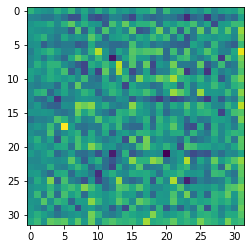

 25%|██▍       | 499/2000 [01:00<02:49,  8.88it/s]

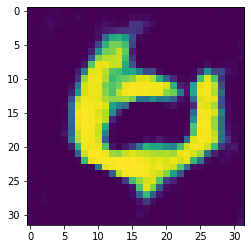

 50%|█████     | 1000/2000 [01:50<01:35, 10.48it/s]

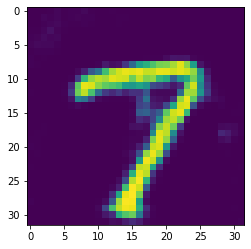

 75%|███████▌  | 1500/2000 [02:48<00:54,  9.11it/s]

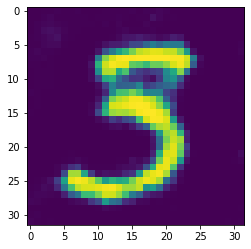

100%|██████████| 2000/2000 [03:45<00:00,  8.87it/s]


In [7]:
g_losses, d_losses = main()

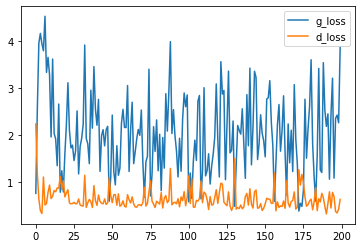

In [8]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()
plt.show()